# Nicholas Tam Final Visualization

## Research Question/Interests
Research question: Given the tree dataset, how would we want to arrange the types of trees to be planted in certain locations, such that they could survive and significantly improve the ecosystem?

Given the research question, it would be ideal to analyze relevant properties, such as the relative sizes of each location and the proportions of planted trees for each species.

The following questions will be used as guidelines to supplement the question:
- What are the numbers and proportions of planted trees, by species and genus?
- Which planted species exist in many different locations within each neighbourhood?
- How do trees that have been planted directly compare in terms of diameter and height to those that have grown naturally?

## Task Analysis
- Compute: Compute the average percentage differences in `DIAMETER` between planted and non-planted trees, and estimate the percentage percentage differences in height between planted and non-planted trees based on `HEIGHT_RANGE`.
- Filter: Filter out `SPECIES_NAME` such that there are plenty of both planted and non-planted trees.
- Characterize distribution: Find the distribution of percentage differences in height for planted tree `SPECIES_NAME` based on `HEIGHT_RANGE`.
- Sort: Rank `SPECIES_NAME` for appearing in the greatest number of `NEIGHBOURHOOD_NAME` and having large proportions of each corresponding`ON_STREET` containing them.
- Retrieve value: Retrieve the number of trees that have been planted, separated by `SPECIES_NAME`.

## Subquestion of interest: Which planted species exist in many different locations within each neighbourhood?

In [1]:
import altair as alt
import pandas as pd
from toolz.curried import pipe
import os
from pygbif import species

import sys
sys.path.append("../../code")
sys.path.append("../../images")
import data_clean
import preprocess_query_family
import preprocess_query_pollen
import preprocess_change_col_type
import altair_data_transformer
from IPython.display import Image
import geopandas as gpd
import json

In [2]:
# Create a new data transformer that stores the files in a directory
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

# Set up file path to save images
viz_folder = '../../images/ntam_viz/'

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('json_dir')

## Processed Data
- Upon loading `public_trees_cleaned_filled_neighbhour.csv`, need to set the attribute types for `HEIGHT_RANGE`, `TREE_ID`, `CIVIC_NUMBER`, and `ON_STREET_BLOCK`.
- `public_trees_planted` is created to filter for species with existing planted trees.

In [3]:
# public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned.csv")
public_trees_cleaned = pd.read_csv("../../data/processed/public_trees_cleaned_filled_neighbhour.csv")
priority_order = ['10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '>90']
public_trees_cleaned['HEIGHT_RANGE'] = pd.Categorical(public_trees_cleaned['HEIGHT_RANGE'], categories=priority_order, ordered=True)
public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']] = public_trees_cleaned[['TREE_ID', 'CIVIC_NUMBER', 'ON_STREET_BLOCK']].astype(str)

public_trees_cleaned.head()

,TREE_ID,CIVIC_NUMBER,STD_STREET,GENUS_NAME,SPECIES_NAME,CULTIVAR_NAME,COMMON_NAME,ON_STREET_BLOCK,ON_STREET,NEIGHBOURHOOD_NAME,...,DIAMETER,DATE_PLANTED,Geom,geo_point_2d,LATITUDE,LONGITUDE,NOMENCLATURE,ON_ADDRESS,FAMILY_NAME,HAS_POLLEN
0,229002,2128,E 54TH AV,FAGUS,SYLVATICA,DAWYCKII,DAWYCK'S BEECH,2100,E 54TH AV,VICTORIA-FRASERVIEW,...,3.0,2014-12-03,"{""coordinates"": [-123.06377300024464, 49.22020...","49.22020099919947, -123.06377300024464",49.220201,-123.063773,FAGUS SYLVATICA,2100 E 54TH AV VICTORIA-FRASERVIEW (EVEN),FAGACEAE,True
1,229005,8443,FREMLIN ST,ACER,TRUNCATUM,PACIFIC SUNSET,PACIFIC SUNSET MAPLE,8400,FREMLIN ST,MARPOLE,...,12.0,2010-08-11,"{""coordinates"": [-123.12751900039063, 49.20967...","49.20967799914094, -123.12751900039063",49.209678,-123.127519,ACER TRUNCATUM,8400 FREMLIN ST MARPOLE (ODD),ACERACEAE,False
2,229013,1407,W 59TH AV,PRUNUS,CERASIFERA,NIGRA,NIGHT PURPLE LEAF PLUM,7400,CARTIER ST,MARPOLE,...,3.0,NaN,"{""coordinates"": [-123.13790199955884, 49.21762...","49.21762499869929, -123.13790199955884",49.217625,-123.137902,PRUNUS CERASIFERA,7400 CARTIER ST MARPOLE (ODD),ROSACEAE,True
3,229015,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-10-12,"{""coordinates"": [-123.11410500027938, 49.26698...","49.26698999931175, -123.11410500027938",49.266990,-123.114105,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False
4,229016,489,W 2ND AV,PYRUS,CALLERYANA,CHANTICLEER,CHANTICLEER PEAR,400,W 2ND AV,MOUNT PLEASANT,...,3.0,2009-10-12,"{""coordinates"": [-123.11399200056373, 49.26704...","49.267045998933334, -123.11399200056373",49.267046,-123.113992,PYRUS CALLERYANA,400 W 2ND AV MOUNT PLEASANT (MED),ROSACEAE,False


In [4]:
planted_species = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull(), 'SPECIES_NAME'].unique()
public_trees_planted = public_trees_cleaned[public_trees_cleaned['SPECIES_NAME'].isin(planted_species)]

## Visualization 2: Which planted species exist in many different locations within each neighbourhood?

In [5]:
gdf = gpd.read_file("../../data/processed/local_area_boundary.geojson")
# gdf['name'] = gdf['name'].str.upper() # To make name compatible with other dataset
gdf['NEIGHBOURHOOD_NAME'] = gdf['name'].str.upper()
gdf

,name,center_lon,center_lat,geometry,NEIGHBOURHOOD_NAME
0,Dunbar-Southlands,-123.189547,49.237962,"POLYGON ((-123.17 49.248, -123.17 49.235, -123...",DUNBAR-SOUTHLANDS
1,Fairview,-123.131049,49.264540,"POLYGON ((-123.15 49.257, -123.15 49.272, -123...",FAIRVIEW
2,Mount Pleasant,-123.098513,49.263065,"POLYGON ((-123.1 49.269, -123.1 49.267, -123.1...",MOUNT PLEASANT
3,Renfrew-Collingwood,-123.040166,49.247343,"POLYGON ((-123.02 49.235, -123.02 49.232, -123...",RENFREW-COLLINGWOOD
4,West End,-123.135438,49.285011,"POLYGON ((-123.14 49.275, -123.14 49.278, -123...",WEST END
5,Arbutus Ridge,-123.161669,49.246805,"POLYGON ((-123.15 49.257, -123.16 49.257, -123...",ARBUTUS RIDGE
6,Grandview-Woodland,-123.066728,49.276440,"POLYGON ((-123.08 49.29, -123.07 49.29, -123.0...",GRANDVIEW-WOODLAND
7,Kensington-Cedar Cottage,-123.072885,49.246686,"POLYGON ((-123.06 49.262, -123.06 49.243, -123...",KENSINGTON-CEDAR COTTAGE
8,Killarney,-123.037647,49.217022,"POLYGON ((-123.02 49.2, -123.04 49.204, -123.0...",KILLARNEY
9,Kitsilano,-123.163295,49.267540,"POLYGON ((-123.14 49.275, -123.14 49.273, -123...",KITSILANO


In [6]:
# Data preparation

# List of trees that have been manually planted
public_trees_manual = public_trees_cleaned.loc[public_trees_cleaned['DATE_PLANTED'].notnull()]

# Species within each street
streets_species_count = public_trees_manual.groupby(['ON_STREET']).agg(NEIGHBOURHOOD_NAME=('NEIGHBOURHOOD_NAME', 'first'), Species_Count=('SPECIES_NAME', 'nunique'),).reset_index()
min_species = 15 

# Number of streets within each neighbourhood
neighborhood_streets_dict = public_trees_cleaned.groupby("NEIGHBOURHOOD_NAME")["ON_STREET"].unique().apply(list).to_dict()
neighborhood_street_counts = {neigh: len(streets) for neigh, streets in neighborhood_streets_dict.items()}
# gdf["NUM_OF_STREETS"] = gdf["name"].map(lambda x: neighborhood_street_counts.get(x, 0)).fillna(0)
gdf["NUM_OF_STREETS"] = gdf["NEIGHBOURHOOD_NAME"].map(lambda x: neighborhood_street_counts.get(x, 0)).fillna(0)

# Define a function to calculate proportions based on a minimum number of species
def calculate_proportions(min_species):
    neighborhood_proportions = {}
    for neighborhood, streets in neighborhood_streets_dict.items():
        total_streets = len(streets)
        if total_streets == 0:
            neighborhood_proportions[neighborhood] = 0
            continue
        streets_with_min_species = sum(
            1 for street in streets if streets_species_count.loc[
                streets_species_count["ON_STREET"] == street, "Species_Count"
            ].sum() >= min_species
        )
        neighborhood_proportions[neighborhood] = streets_with_min_species / total_streets
    return neighborhood_proportions

neighborhood_proportions = calculate_proportions(min_species)
# gdf["SPECIES_PROP"] = gdf["name"].map(lambda x: neighborhood_proportions.get(x, 0)).fillna(0)
gdf["SPECIES_PROP"] = gdf["NEIGHBOURHOOD_NAME"].map(lambda x: neighborhood_proportions.get(x, 0)).fillna(0)


# Convert GeoDataFrame to GeoJSON format
geojson_data = json.loads(gdf.to_json())

In [11]:
# Create a selection for clicking on a neighborhood on the map
neighborhood_click = alt.selection_point(
    # fields=["properties.name"],  # Selecting based on GeoJSON neighborhood name
    fields=["properties.NEIGHBOURHOOD_NAME"],
    name="NEIGHBOURHOOD_NAME", 
    clear=True,
    empty=True,
)
selection = alt.selection_point(fields=['NEIGHBOURHOOD_NAME'], bind='legend')

lookup_data_species = alt.LookupData(streets_species_count, key="NEIGHBOURHOOD_NAME", fields=["Species_Count"])
# lookup_data_map = alt.LookupData(alt.Data(values=geojson_data["features"]), key="properties.name",)
# lookup_data_map = alt.LookupData(alt.Data(values=geojson_data["features"]), key="properties.NEIGHBOURHOOD_NAME",)

# Choropleth showing proportions
tree_map = alt.Chart(alt.Data(values=geojson_data["features"])).mark_geoshape(
    stroke='#706545'
).transform_lookup( # To get coordinates into shape
    # lookup="properties.name",  # Matching GeoJSON neighborhood names
    lookup="properties.NEIGHBOURHOOD_NAME",
    from_=lookup_data_species  # Lookup from species count dataset
).encode(
    color=alt.Color(
        "properties.SPECIES_PROP:Q",
        title="Proportion",
        scale=alt.Scale(scheme='viridis', reverse=True),
        legend=alt.Legend(orient="left")  # Position legend on the left
    ),
    opacity=alt.condition(neighborhood_click, alt.value(1), alt.value(0.1)),
    tooltip=[
        # alt.Tooltip("properties.name:N", title="Neighborhood"),
        alt.Tooltip("properties.NEIGHBOURHOOD_NAME:N", title="Neighborhood"),
        alt.Tooltip("properties.NUM_OF_STREETS:Q", title="Number of Streets"),
        alt.Tooltip("properties.SPECIES_PROP:Q", title="Tree Species Proportion", format=".2%")
    ]
).properties(
    width=600,
    height=400,
    title=f"Proportion of Streets with At Least {min_species} Different Species"
).project(type='identity', reflectY=True).add_params(neighborhood_click)

# Bar plot showing streets and number of unique species in the selected neighborhood
range_2 = ['#FFC20A', '#0C7BDC', '#CC79A7', '#4B0092', '#009E73', '#D35FB7', '#994F00', '#006CD1',
          '#E1BE6A', '#40B0A6', '#005AB5', '#DC3220', '#5D3A9B', '#E66100', '#1A85FF', '#D4AA59',
          '#332288', '#117733', '#44AA99', '#88CCEE', '#DDCC77', '#CC6677', '#AA4499', '#882255']

bar_chart = alt.Chart(streets_species_count).mark_bar().encode(
    alt.Y('ON_STREET:N', sort='color'),
    alt.X('Species_Count:Q', title='Unique Species Count'),
    # alt.Color('NEIGHBOURHOOD_NAME', scale=alt.Scale(scheme="tableau20")),
    alt.Color('NEIGHBOURHOOD_NAME', scale=alt.Scale(range=range_2)),
    tooltip=[
        alt.Tooltip("NEIGHBOURHOOD_NAME:N", title="Street"),
        alt.Tooltip("ON_STREET:N", title="Street"),
        alt.Tooltip("Species_Count:Q", title="Tree Species Count"),
    ],
).add_params(
    selection
).transform_filter(
    neighborhood_click
).properties(
    width=200,
    title="Unique Species Count by Street"
).transform_filter(
    selection
)
# .transform_lookup(
#     lookup="properties.NEIGHBOURHOOD_NAME",  # Matching GeoJSON neighborhood names
#     from_=lookup_data_map  # Lookup from species count dataset
# )

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/core.py:395: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/opt/anaconda3/lib/python3.12/site-packages/altair/utils/c

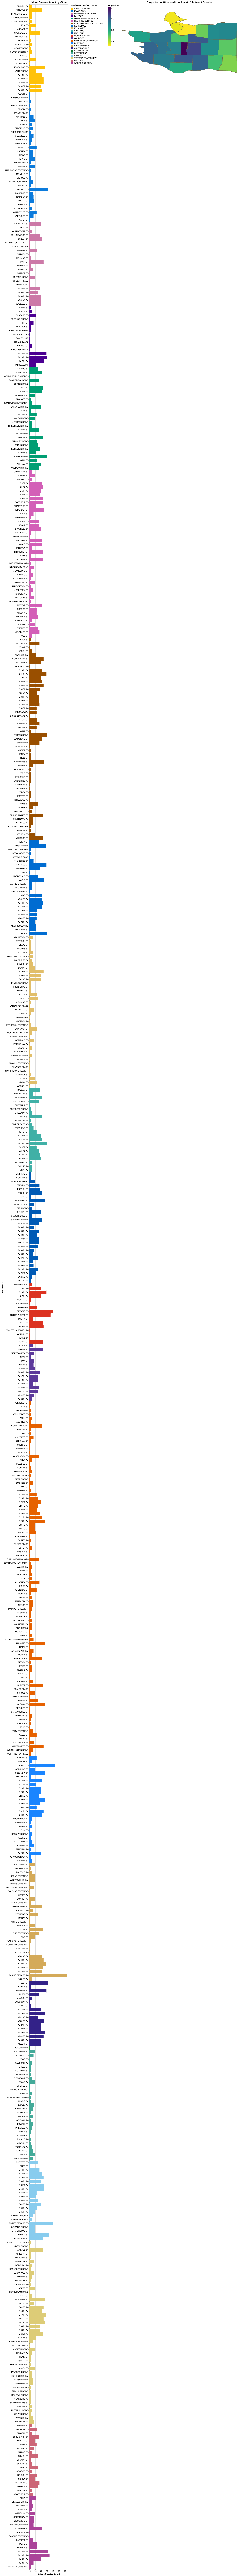

In [12]:
viz2 = bar_chart | tree_map
viz2.save(viz_folder+'plant_viz2.html')
viz2